<a href="https://colab.research.google.com/github/DimOriCoding/Artificial_Intelligence_II/blob/main/Assignment_4_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 44.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 95.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 19.6 MB/s eta 0:00:00


In [ ]:
!nvidia-smi

Tue Feb 28 12:48:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    25W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import random
import os
import numpy as np
import torch
import torch.nn as nn



def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run. This is for REPRODUCIBILITY.
    '''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device available for running: ")
print(device)

Device available for running: 
cuda


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
dataset = pd.read_csv('imdb-reviews.csv', sep = '\t')
dataset.describe()
row_count_train = sum(1 for rows in dataset["url"])

In [ ]:
import string
import re
from collections import Counter

def remove_duplicates(text):

    # split input string separated by space
    text = text.split(" ")

    # now create dictionary using counter method
    # which will have strings as key and their
    # frequencies as value
    UniqW = Counter(text)

    # joins two adjacent elements in iterable way
    text = " ".join(UniqW.keys())
    return text
def basic_preprocessing(text):
  # Remove urls
  text = re.sub(r'https?://\S+',' ',str(text))
  # Remove tags
  text = re.sub(r'@\s?\w+',' ',text)
  # Remove underscore characters
  text = re.sub(r'_', ' ', text)
  # remove numbers
  text = re.sub(r'\d+', '', text)
  # Remove \r and \n
  text = re.sub(r'[\r\n]',' ', text)
    # Remove single characters
  text = re.sub(r'\s+[a-zA-Z]\s+', ' ',text)
  # Remove single characters from start
  text = re.sub(r'^[a-zA-Z]\s+', '', text)
    # Remove single characters from end
  text = re.sub(r'\s+[a-zA-Z]$', '', text)
  # Remove special characters
  text = re.sub(r'\n',' ', text)
  text = re.sub(r'\r', ' ', text)
  # Removing prefixed 'b'
  text = re.sub(r'^b\s+', '', text)
    # Convert multiple spaces to single space and remove beginning and end spaces
  text = re.sub(r' +',' ',text).strip()
  return text
def get_sentiment(rating):
  if rating<=4.0:
    return 0.0 #negative sentiment rating <= 4.0
  else:
    return 1.0 #positive sentiment rating >= 7.0

dataset['review'] = dataset['review'].apply(lambda x:basic_preprocessing(x))
dataset['review'] = dataset['review'].apply(lambda x:remove_duplicates(x))
dataset['rating'] = dataset['rating'].apply(get_sentiment)
dataset.head()

,url,rating,review
0,http://www.imdb.com/title/tt0120623/usercomments,1.0,thought this was quiet good movie. It fun to w...
1,http://www.imdb.com/title/tt0043117/usercomments,1.0,Wagon Master is very unique film amongst John ...
2,http://www.imdb.com/title/tt0043117/usercomments,1.0,This film has to be as near perfect John Ford ...
3,http://www.imdb.com/title/tt0835204/usercomments,0.0,gave this stars because it has lot of interest...
4,http://www.imdb.com/title/tt0499603/usercomments,1.0,This movie is really genuine and random. It's ...


In [ ]:
from transformers import BertModel, BertTokenizerFast
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
from sklearn.model_selection import train_test_split
train_dataset , valid_dataset = train_test_split(dataset, test_size = 0.2, random_state = 1234)
validation_dataset, test_dataset = train_test_split(valid_dataset, test_size = 0.5, random_state = 1234)
print(train_dataset.shape,valid_dataset.shape,validation_dataset.shape,test_dataset.shape)

(40350, 3) (10088, 3) (5044, 3) (5044, 3)


In [ ]:
class BertReviewsDataset:
  def __init__(self, reviews, ratings, tokenizer, max_len):
    self.reviews = reviews
    self.ratings = ratings
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.reviews)

  def __getitem__(self, idx):
    review = str(self.reviews[idx])
    encoding = self.tokenizer.encode_plus(review ,add_special_tokens = True, max_length = self.max_len, return_token_type_ids=False,
                                        truncation = True, padding = 'max_length',  return_attention_mask = True, return_tensors='pt').to(device)
    return {'review' :  review,
                'input_id': encoding['input_ids'].flatten(),
                'attention_mask':encoding['attention_mask'].flatten(),
                'rating': torch.tensor(self.ratings[idx], dtype = torch.float, device = device)
               }

1116


/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


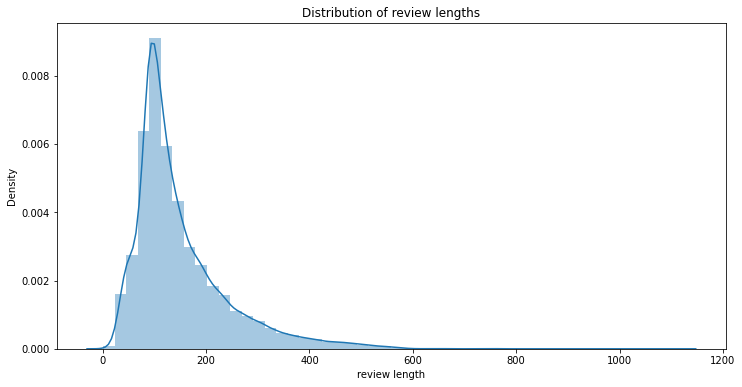

In [ ]:
#Decide max length sequence through plotting a distribution graph for the number
#of words in each review. The value of max_len is the values for which most
#of the review is covered without truncation.
import seaborn as sns
lengths = np.array([len(x.split()) for x in dataset['review'].values])
plt.figure(figsize = (12,6))
print(max(lengths))
sns.distplot(lengths)
plt.xlabel('review length')
plt.title('Distribution of review lengths')
plt.show()

In [ ]:
train_bert_dataset = BertReviewsDataset(train_dataset['review'].to_numpy(), train_dataset['rating'].to_numpy(), tokenizer=tokenizer, max_len=125)
valid_bert_dataset = BertReviewsDataset(valid_dataset['review'].to_numpy(), valid_dataset['rating'].to_numpy(), tokenizer=tokenizer, max_len=512)
print(len(train_bert_dataset),len(valid_bert_dataset))

40350 10088


In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

train_loader = DataLoader(train_bert_dataset, batch_size=32, shuffle = True)
valid_loader = DataLoader(valid_bert_dataset, batch_size=8, shuffle = True)


In [ ]:
class BertClassifier(nn.Module):
  def __init__(self, dropout):
    super(BertClassifier, self).__init__()
    self.bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
# Whether the model returns all hidden-states.
    self.dropout = nn.Dropout(dropout)
    self.fc1 = nn.Linear(768, 512, device=device)
    self.fc2 = nn.Linear(512, 256, device=device)
    self.fc3 = nn.Linear(256, 1, device=device)

    self.sigmoid = nn.Sigmoid()

  def forward(self, input_ids, att_mask):
    out = self.bert_model(input_ids, att_mask)
    out = self.dropout(out[1])#CLS token-pooled output
    out = self.fc1(out)
    out = self.dropout(out)
    out = self.fc2(out)
    out = self.dropout(out)
    out = self.fc3(out)
    out = self.sigmoid(out)
    return out

In [ ]:
from torch.optim import Adam,AdamW
from transformers import get_linear_schedule_with_warmup
#Define Hyperparameters
learning_rate = 1e-5
model = BertClassifier(dropout=0.05).to(device)
print(model)
epochs = 3
loss_func = nn.BCELoss().to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate, eps = 1e-8)
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=epochs*len(train_loader)
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi

Epoch   0: Train Loss = 0.32359
Epoch   0: Train precision = 0.86225
Epoch   0: Train recall = 0.86091
Epoch   0: Train f1 score = 0.85507
Epoch   0: Train accuracy = 0.86010


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0

Epoch   0: Valid Loss = 0.19828
Epoch   0: Valid precision = 0.90183
Epoch   0: Valid recall = 0.94955
Epoch   0: Valid f1_score = 0.91606
Epoch   0: Acurracy = 0.92674
Epoch   1: Train Loss = 0.20309
Epoch   1: Train precision = 0.92076
Epoch   1: Train recall = 0.92368
Epoch   1: Train f1 score = 0.91957
Epoch   1: Train accuracy = 0.92159


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Re

Epoch   1: Valid Loss = 0.18555
Epoch   1: Valid precision = 0.93445
Epoch   1: Valid recall = 0.93187
Epoch   1: Valid f1_score = 0.92340
Epoch   1: Acurracy = 0.93656
Epoch   2: Train Loss = 0.14827
Epoch   2: Train precision = 0.94815
Epoch   2: Train recall = 0.94876
Epoch   2: Train f1 score = 0.94683
Epoch   2: Train accuracy = 0.94843


/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is 

Epoch   2: Valid Loss = 0.19762
Epoch   2: Valid precision = 0.93480
Epoch   2: Valid recall = 0.92736
Epoch   2: Valid f1_score = 0.92176
Epoch   2: Acurracy = 0.93735


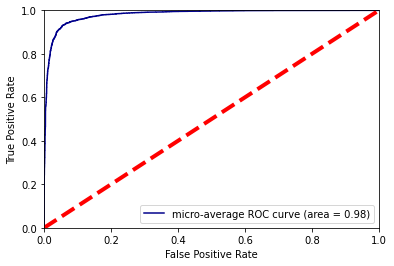

Text(0.5, 1.0, 'loss-score')

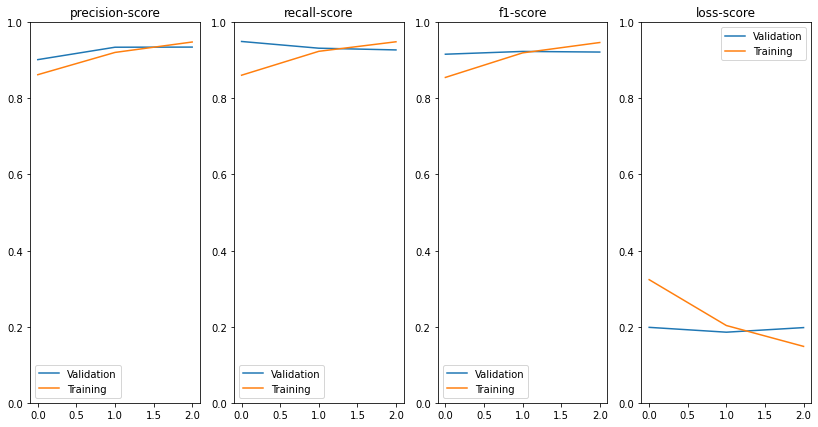

In [ ]:
from sklearn.metrics import f1_score,recall_score,precision_score,classification_report,roc_curve,auc,accuracy_score
from sklearn.preprocessing import label_binarize

list_loss_train = []
list_epochs = []
list_loss = []
list_f1_scores_train = []
list_f1_scores = []
list_recalls_train = []
list_recalls = []
list_precisions_train = []
list_precisions = []
for epoch in range(epochs):
  model.train()
  batch_losses = []
  batch_f1_scores = []
  batch_recalls = []
  batch_precisions = []
  batch_accuracy = []
  for batch in train_loader:
   input_ids = batch['input_id'].to(device)
   attention_masks = batch['attention_mask'].to(device)
   ratings = batch['rating'].to(device)
   y_pred = model(input_ids, attention_masks)
   loss = loss_func(y_pred.squeeze().cpu(),ratings.cpu())
   batch_losses.append(loss.detach().numpy())
   preds = torch.round(y_pred).squeeze()
   Preds = preds.tolist()
   Y_batch = ratings.tolist()
   batch_f1_scores.append(f1_score(Y_batch, Preds))
   batch_recalls.append(recall_score(Y_batch, Preds))
   batch_precisions.append(precision_score(Y_batch, Preds))
   batch_accuracy.append(accuracy_score(Y_batch, Preds))
    #Delete previously stored gradients
   optimizer.zero_grad()

    #Perform backpropagation starting from the loss calculated in this epoch
   loss.backward()
   nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    #Update model's weights based on the gradients calculated during backprop
   optimizer.step()
   scheduler.step()
  print(f"Epoch {epoch:3}: Train Loss = {sum(batch_losses)/len(train_loader):.5f}")
  print(f"Epoch {epoch:3}: Train precision = {sum(batch_precisions)/len(train_loader):.5f}")
  print(f"Epoch {epoch:3}: Train recall = {sum(batch_recalls)/len(train_loader):.5f}")
  print(f"Epoch {epoch:3}: Train f1 score = {sum(batch_f1_scores)/len(train_loader):.5f}")
  print(f"Epoch {epoch:3}: Train accuracy = {sum(batch_accuracy)/len(train_loader):.5f}")
  list_loss_train.append(sum(batch_losses)/len(train_loader))
  list_f1_scores_train.append(sum(batch_f1_scores)/len(train_loader))
  list_precisions_train.append(sum(batch_precisions)/len(train_loader))
  list_recalls_train.append(sum(batch_recalls)/len(train_loader))


  with torch.no_grad():
    model.eval()
    Y_batches = []
    Y_preds = []
    F1 = []
    precision = []
    recall = []
    accuracy = []
    batch_losses_val = []
    for batch in valid_loader:
      input_ids = batch['input_id'].to(device)
      attention_masks = batch['attention_mask'].to(device)
      ratings = batch['rating'].to(device)
      y_predict = model(input_ids, attention_masks)
      val_loss = loss_func(y_predict.squeeze().cpu(),ratings.cpu())
      batch_losses_val.append(val_loss)
      y_pr = torch.round(y_predict).squeeze()

      Y_p = y_pr.tolist()
      y_val = ratings.tolist()
      F1.append(f1_score(y_val, Y_p))

      precision.append(precision_score(y_val, Y_p))
      recall.append(recall_score(y_val, Y_p))
      accuracy.append(accuracy_score(y_val,Y_p))
      Y_batches.append(ratings)
      Y_preds.append(y_predict)

    Y_batches = torch.cat(Y_batches)
    Y_preds = torch.cat(Y_preds)
    print(f"Epoch {epoch:3}: Valid Loss = {sum(batch_losses_val)/len(valid_loader):.5f}")
    print(f"Epoch {epoch:3}: Valid precision = {sum(precision)/len(valid_loader):.5f}")
    print(f"Epoch {epoch:3}: Valid recall = {sum(recall)/len(valid_loader):.5f}")
    print(f"Epoch {epoch:3}: Valid f1_score = {sum(F1)/len(valid_loader):.5f}")
    print(f"Epoch {epoch:3}: Acurracy = {sum(accuracy)/len(valid_loader):.5f}")
    list_f1_scores.append(sum(F1)/len(valid_loader))
    list_loss.append(sum(batch_losses_val)/len(valid_loader))
    list_precisions.append(sum(precision)/len(valid_loader))
    list_recalls.append(sum(recall)/len(valid_loader))
    list_epochs.append(epoch)
  if(epoch == (epochs-1)):
   Y_label = label_binarize(Y_batches.cpu(), classes=[0, 1])

   fpr, tpr, _ = roc_curve(Y_label, Y_preds.cpu())
   roc_auc= auc(fpr, tpr)
   plt.figure()
   plt.plot(
     fpr,
     tpr,
     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc),
     color="darkblue",
     )

   plt.plot([0, 1], [0, 1], color="red",lw=4, linestyle="--")
   plt.xlim([0.0, 1.0])
   plt.ylim([0.0, 1.0])
   plt.xlabel("False Positive Rate")
   plt.ylabel("True Positive Rate")
   plt.legend(loc="lower right")
   plt.show()
plt.subplots(1,4, figsize = (14,7))
plt.subplot(1,4,1)
plt.plot(list_epochs, list_precisions)
plt.plot(list_epochs, list_precisions_train)
plt.ylim(ymin = 0.0 ,ymax = 1.0)
plt.legend(["Validation", "Training"])
plt.title("precision-score")

plt.subplot(1,4,2)
plt.plot(list_epochs, list_recalls)
plt.plot(list_epochs, list_recalls_train)
plt.ylim(ymin = 0.0 ,ymax = 1.0)
plt.legend(["Validation", "Training"])
plt.title("recall-score")

plt.subplot(1,4,3)
plt.plot(list_epochs, list_f1_scores)
plt.plot(list_epochs, list_f1_scores_train)
plt.ylim(ymin = 0.0 ,ymax = 1.0)
plt.legend(["Validation", "Training"])
plt.title("f1-score")

plt.subplot(1,4,4)
plt.plot(list_epochs, list_loss)
plt.plot(list_epochs, list_loss_train)
plt.ylim(ymin = 0.0, ymax = 1.0)
plt.legend(["Validation", "Training"])
plt.title("loss-score")

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is 

Epoch 2: Test Loss = 0.18187
Epoch 2: Test precision = 0.94899
Epoch 2: Test recall = 0.93600
Epoch 2: Test f1_score = 0.93448
Epoch 2: Test Acurracy = 0.94235


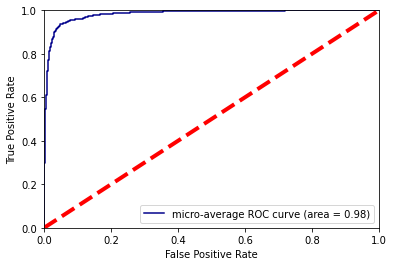

In [ ]:
#Test set predictions
if test_dataset is not None:
 test_bert_dataset = BertReviewsDataset(test_dataset['review'].to_numpy(), test_dataset['rating'].to_numpy(), tokenizer=tokenizer, max_len=512)
 test_loader = DataLoader(test_bert_dataset, batch_size=8,shuffle = True)
 with torch.no_grad():
    model.eval()
    Y_batches = []
    Y_preds = []
    F1 = []
    precision = []
    recall = []
    accuracy = []
    batch_losses_val = []
    for batch in test_loader:
      input_ids = batch['input_id'].to(device)
      attention_masks = batch['attention_mask'].to(device)
      ratings = batch['rating'].to(device)
      y_predict = model(input_ids, attention_masks)
      val_loss = loss_func(y_predict.squeeze().cpu(),ratings.cpu())
      batch_losses_val.append(val_loss)
      y_pr = torch.round(y_predict).squeeze()

      Y_p = y_pr.tolist()
      y_val = ratings.tolist()
      F1.append(f1_score(y_val, Y_p))

      precision.append(precision_score(y_val, Y_p))
      recall.append(recall_score(y_val, Y_p))
      accuracy.append(accuracy_score(y_val,Y_p))
      Y_batches.append(ratings)
      Y_preds.append(y_predict)

    Y_batches = torch.cat(Y_batches)
    Y_preds = torch.cat(Y_preds)
    print(f"Epoch {epoch:1}: Test Loss = {sum(batch_losses_val)/len(test_loader):.5f}")
    print(f"Epoch {epoch:1}: Test precision = {sum(precision)/len(test_loader):.5f}")
    print(f"Epoch {epoch:1}: Test recall = {sum(recall)/len(test_loader):.5f}")
    print(f"Epoch {epoch:1}: Test f1_score = {sum(F1)/len(test_loader):.5f}")
    print(f"Epoch {epoch:1}: Test Acurracy = {sum(accuracy)/len(test_loader):.5f}")

 Y_label = label_binarize(Y_batches.cpu(), classes=[0, 1])

 fpr, tpr, _ = roc_curve(Y_label, Y_preds.cpu())
 roc_auc= auc(fpr, tpr)

 plt.figure()
 plt.plot(
     fpr,
     tpr,
     label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc),
     color="darkblue",
     )

 plt.plot([0, 1], [0, 1], color="red",lw=4, linestyle="--")
 plt.xlim([0.0, 1.0])
 plt.ylim([0.0, 1.0])
 plt.xlabel("False Positive Rate")
 plt.ylabel("True Positive Rate")
 plt.legend(loc="lower right")
 plt.show()




In [ ]:
#Saving the model of Bert Classifier
torch.save(model.state_dict(), ('BertClassifier.pt'))
model.load_state_dict(torch.load('BertClassifier.pt'))
model.eval()

BertClassifier(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affi